In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# note: The total employment data in the priginal source  is presented in thousands(i.e. 250 means 250,000)
url1 = "https://www.bls.gov/web/laus/laumstcm.htm" #unemployment rate by state
url2= "https://www.bls.gov/web/empsit/ceseeb1a.htm"#employment by sectors
url3 ="https://www.bls.gov/web/laus/statewide_otm_oty_change.htm"#employment by state 
html1 = urlopen(url1)
html2 = urlopen(url2)
html3= urlopen(url3)

In [3]:
soup1 = BeautifulSoup(html1, 'lxml')
soup2 = BeautifulSoup(html2, 'lxml')
soup3 = BeautifulSoup(html3, 'lxml')

In [4]:
## Process Data for employment Rates
states= soup1.table.find_all('p')
change = soup1.table.find_all('tr')
text1 = soup1.get_text()
text2 = soup2.get_text()

# Filter out irrlevant texts and sort data into a table
texts= [ch.text for ch in change ]
texts=texts[1:]
obs = [ p.split('\n') for p in texts][2:]
obs
feature_title = {'State': [], 'March 2020 rate': [], 'April 2020 rate': [], 'Over-the-month Change':[],'Rank':[]}
for ob in obs:
    feature_title["State"].append(ob[0])
    feature_title["March 2020 rate"].append(ob[1])
    feature_title["April 2020 rate"].append(ob[2])
    feature_title["Over-the-month Change"].append(ob[3])
    feature_title["Rank"].append(ob[4])
d= pd.DataFrame.from_dict(feature_title)
d.head()

,State,March 2020 rate,April 2020 rate,Over-the-month Change,Rank
0,Nebraska,4.0,8.3,4.3,1
1,Connecticut,3.4,7.9,4.5,2
2,New Mexico,6.3,11.3,5.0,3
3,District of Columbia,6.0,11.1,5.1,4
4,Arkansas,5.0,10.2,5.2,5


In [5]:
## Proces data for different sectors
data = soup2.table.find_all('span',{"class": "datavalue"})
sectors= soup2.table.find_all('p',{"class": ["sub0","sub1","sub2","sub3","sub4","sub5","sub6","sub7","sub8","sub9"]})
dt = [d.text for d in data ]
sec = [s.text for s in sectors]

#Make the dataframe
def string_to_float(x):
    if x=='-':
        return x
    return float(''.join(x.split(',')))
   
feature_title = {'Sector':[],'Apr2019': [], 'Dec2019': [], 'Jan2020': [], 'Feb2020':[],'Mar2020':[],'Apr2020':[],'Change':[]}
i=0
j=0

while i<len(dt):

    feature_title['Sector'].append(sec[j])
    feature_title['Apr2019'].append(string_to_float(dt[i]))
    feature_title['Dec2019'].append(string_to_float(dt[i+1]))
    feature_title['Jan2020'].append(string_to_float(dt[i+2]))
    feature_title['Feb2020'].append(string_to_float(dt[i+3]))
    feature_title['Mar2020'].append(string_to_float(dt[i+4]))
    feature_title['Apr2020'].append(string_to_float(dt[i+5]))
    feature_title['Change'].append(string_to_float(dt[i+6]))
    i+=7
    j+=1
   
d2= pd.DataFrame.from_dict(feature_title)
d2.head()

,Sector,Apr2019,Dec2019,Jan2020,Feb2020,Mar2020,Apr2020,Change
0,Total nonfarm,150577.0,152212.0,152463.0,151090.0,130403.0,132912,2509
1,Total private,128026.0,129498.0,129718.0,128362.0,108638.0,111732,3094
2,Goods-producing,21050.0,21149.0,21205.0,21086.0,18713.0,19382,669
3,Mining and logging,743.0,712.0,714.0,706.0,652.0,632,-20
4,Logging,49.5,53.8,54.5,54.5,49.7,50.1,0.4


In [6]:
## Filter data to visualize distribution of employements in super sectors 
boolean = d2["Sector"].isin(["Service-providing","Goods-producing",'Total nonfarm'])
overall=d2[boolean]

df= overall.set_index('Sector').T.reset_index()[:6]
df.columns = ['Timestamp', 'Total nonfarm', 'Goods-producing','Service-providing']


df_p=df.copy()
df_p['Service-providing']=df_p['Service-providing']*100/df_p['Total nonfarm']
df_p['Goods-producing']=df_p['Goods-producing']*100/df_p['Total nonfarm']
df_p['Goods-producing']=df_p['Goods-producing']

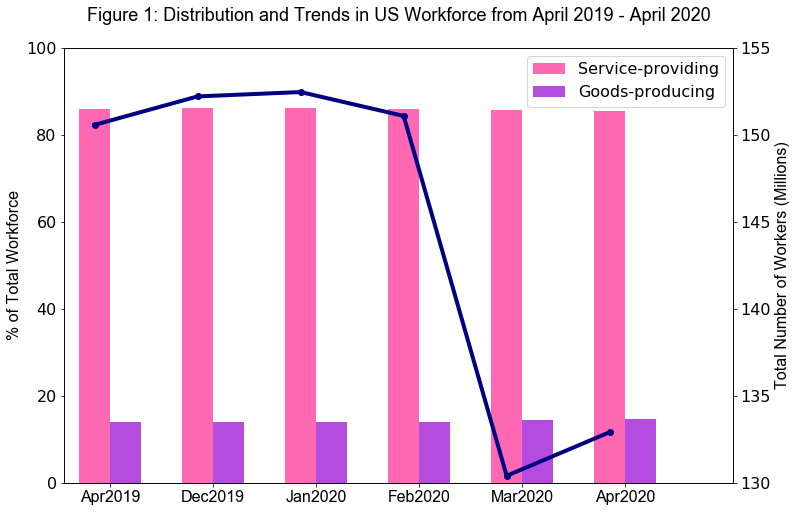

<Figure size 432x288 with 0 Axes>

In [7]:
## Plot employment trend and distrubution

# fontsize 
font_s = 16
line_th = 2
df_p

# Setting the positions and width for the bars
pos = list(range(len(df_p["Timestamp"]))) 
width = 0.3
    
# Plotting the bars
fig,ax= plt.subplots(figsize=(12,8))
ax2 = ax.twinx()

ax2.set_ylabel('Total Number of Workers (Millions)',fontsize=font_s,fontname='Arial')
ax2.tick_params(axis="y", labelsize=font_s)
ax2.set_ylim([130,155])


# Create a bar in position po for service providing
ax.bar(pos, 
        #using df['pre_score'] data,
        df_p['Service-providing'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#FF69B4')
        # with label the first value in first_name
        #label=df['Sector'][0]) 

# Create a bar in position po for goods-producing
ax.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df_p['Goods-producing'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.7, 
        # with color
        color='#9400D3')
        # with label the second value in first_name
        #label=df['first_name'][1]) 



ax2 = plt.plot(df_p["Timestamp"],df_p['Total nonfarm']/1000,marker='o', c='navy', linewidth=4)
        
# Set the y axis label
ax.set_ylabel('% of Total Workforce',fontsize=font_s,fontname='Arial')


# Set the chart's title
ax.set_title('Figure 1: Distribution and Trends in US Workforce from April 2019 - April 2020\n',fontsize = font_s+2,fontname='Arial')

# Set the position of the x ticks
ax.set_xticks([p + 0.5* width for p in pos])


# Set the labels for the x ticks
ax.set_xticklabels(df['Timestamp'], fontsize = font_s,fontname='Arial')
ax.tick_params(axis="y", labelsize=font_s)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)

ax.set_ylim([0,100])


# Adding the legend and showing the plot
ax.legend(['Service-providing', 'Goods-producing','Total WorkForce'], loc='upper right',fontsize= font_s)
#plt.grid()
plt.show()
plt.savefig('US_Workforce_Trends.png')

C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.


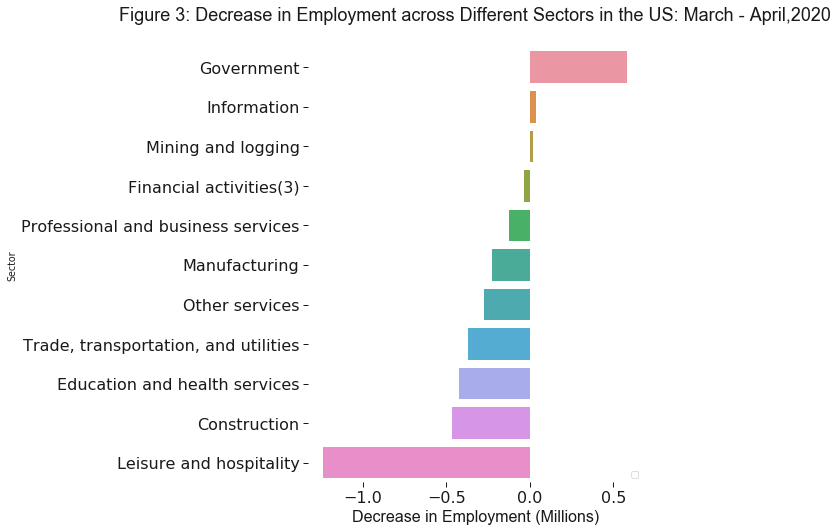

<Figure size 432x288 with 0 Axes>

In [75]:
## Plot employment in the subsectors
#scrape the name of the main subsectors 
sec= soup2.table.find_all('p',{"class": "sub3"})
sub_sectors = [p.text for p in sec]
# Filer out data for subsectors
boolean = d2["Sector"].isin(sub_sectors)
overall=d2[boolean]
overall.Change=overall.Change.apply(lambda x: -string_to_float(x) if isinstance(x, float)==False else -x)
overall.Change=overall.Change/1000
overall.Apr2020=overall.Apr2020.apply(lambda x: string_to_float(x) if isinstance(x, float)==False else x)
overall.sort_values(by='Change', ascending=False,inplace= True)


# plot the data for subsectors
sns.set_context('paper')

f, ax = plt.subplots(figsize = (6,8))
sns.set_color_codes('pastel')
sns.barplot(x = 'Change', y = 'Sector', data = overall)
sns.set_color_codes('muted')
ax.legend(ncol = 2, loc = 'lower right')
# Set the labels for the x ticks
ax.set_xlabel('Decrease in Employment (Millions)',fontsize=font_s,fontname='Arial')
ax.tick_params(axis="x", labelsize=font_s)
ax.tick_params(axis="y", labelsize=font_s)
# Set the chart's title
ax.set_title('Figure 3: Decrease in Employment across Different Sectors in the US: March - April,2020\n',fontsize = font_s+2,fontname='Arial')
sns.despine(left = True, bottom = True)
plt.show()
plt.savefig('unemployment_by_sectors.png')

C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

<Figure size 648x432 with 0 Axes>

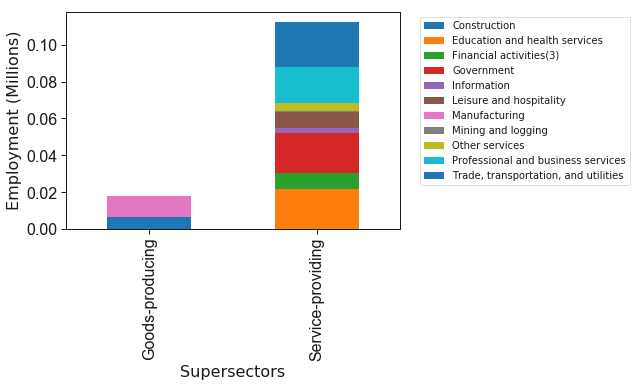

In [10]:
## Goods producing vs service providing
overall["Mar2020"]=overall["Mar2020"]/1000
overall["% Decrease"]=overall["Change"]*100/overall["Mar2020"]
overall_p = overall[["Sector","% Decrease"]]
overall_p.sort_values(by="% Decrease",ascending = False)

def assign_supersector (sector):
        if sector in ["Manufacturing","Construction","Mining and Logging"]:
            return str('Goods-producing')
        else:
            return str('Service-providing')
overall['Supersector']=overall['Sector'].apply(lambda x: assign_supersector(x))
#convert necessary data to millions
overall.Apr2020=overall.Apr2020/1000
overall.Mar2020=overall.Mar2020/1000
df3= pd.pivot_table(overall,index=["Sector","Supersector"],values=["Mar2020"],aggfunc='sum').reset_index()
df3 = df3.pivot(index='Sector', columns='Supersector', values='Mar2020')

plt.figure(figsize=(9,6))
df3.T.plot(kind='bar', stacked=True)
plt.ylabel("Employment (Millions)", fontsize=16)
plt.xlabel("Supersectors", fontsize=16)
plt.xticks(fontsize=font_s,fontname="Arial")#,rotation = 90)
plt.yticks(fontsize=font_s,fontname="Arial")
#plt.title("Contribution of Different Sectors Towards Employment in the US",fontsize=font_s+2,fontname="Arial")
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1),prop={'size':10})#,ncol=3)
plt.savefig('unemployment_by_sector.png')

C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


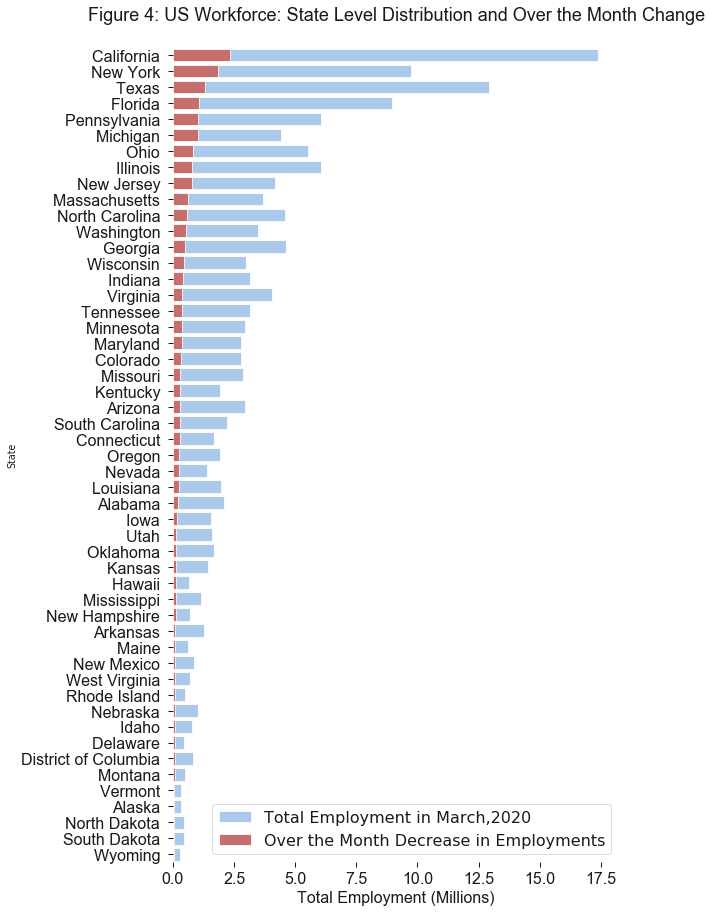

<Figure size 432x288 with 0 Axes>

In [90]:
## Process Data for employment on State level
states= soup3.table.find_all('p')
change = soup3.table.find_all('tr')
Mar_data = soup3.table.find_all()
text1 = soup3.get_text()
text2 = soup3.get_text()

# Filter out irrlevant texts and sort data into a table
texts= [ch.text for ch in change ]

obs = [ p.split('\n') for p in texts][2:]
obs
emp_state= {'State': [], 'Apr2019': [], 'Mar2020': [], 'Apr2020':[],'Over-the-month-net-decrease':[],'Over-the-month-percent-decrease':[]}
for ob in obs[:len(obs)-1]:
  
    emp_state['State'].append(ob[1])
    emp_state['Apr2019'].append(string_to_float(ob[2])/1000)#convert to float and then in millions
    emp_state['Mar2020'].append(string_to_float(ob[3])/1000)#convert to float and then in millions
    emp_state['Apr2020'].append(string_to_float(ob[4])/1000)#convert to float and then in millions
    emp_state['Over-the-month-net-decrease'].append(-float(ob[5])/1000)#convert to float and then  millions
    emp_state['Over-the-month-percent-decrease'].append(-float(ob[6]))
   

   
d3= pd.DataFrame.from_dict(emp_state)
d3.sort_values(by='Over-the-month-net-decrease',ascending= False,inplace=True)
#d3.to_csv('emp_state+mar_apr_2020.csv')

f, ax = plt.subplots(figsize = (8,15))
sns.set_color_codes('pastel')
sns.barplot(x = 'Mar2020', y = 'State', data = d3,
            label = 'Total Employment in March,2020', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'Over-the-month-net-decrease', y = 'State', data = d3,
            label = 'Over the Month Decrease in Employments', color = 'r', edgecolor = 'w')
plt.xlabel("Total Employment (Millions)", fontsize=font_s,fontname="Arial")
plt.xticks(fontsize=font_s,fontname="Arial")
plt.yticks(fontsize=font_s,fontname="Arial")
ax.legend(ncol = 1, loc = 'bottom right',fontsize=font_s)
sns.despine(left = True, bottom = True)
plt.title("Figure 4: US Workforce: State Level Distribution and Over the Month Change\n",fontsize=font_s+2,fontname='Arial')
plt.show()
plt.savefig('unemployment_by_state.png')


In [12]:
d3.sort_values(by='Over-the-month-percent-decrease',ascending= False,inplace=True)
percentage_rank = d3[['State','Over-the-month-percent-decrease']][:10]
percentage_rank["Rank"]=[i for i in range(1,11)]
percentage_rank=percentage_rank[['Rank','State','Over-the-month-percent-decrease']]
percentage_rank.columns=['Rank','State','% Decrease']
percentage_rank

,Rank,State,% Decrease
22,1,Michigan,22.8
45,2,Vermont,19.6
32,3,New York,18.8
11,4,Hawaii,18.6
30,5,New Jersey,18.2
39,6,Rhode Island,17.8
28,7,Nevada,17.4
21,8,Massachusetts,17.0
38,9,Pennsylvania,17.0
7,10,Delaware,16.1


In [86]:
##AS BLS updates  Data in the same url, the section below is adjusted to calculate change from March- Apr from the report published in June. Do not use this code as it is for other reports
#scrape the name of the industries
sec= soup2.table.find_all('p',{"class": "sub4"})
sub_sectors = [p.text for p in sec]
# Filer out data for subsectors
boolean = d2["Sector"].isin(sub_sectors)
overall=d2[boolean]
overall["Decrease_mar_apr"] = overall.Mar2020-overall.Feb2020
overall.Decrease_mar_apr=-overall.Decrease_mar_apr.astype(float)/1000
overall.sort_values(by='Decrease_mar_apr', ascending=False,inplace= True)
overall.Sector.loc[66]="Durable_goods_manf"
overall.Sector.loc[66]="Durable_goods_trade"
overall.Sector.loc[211]="Nondurable_goods_manf"
overall.Sector.loc[339]="Nondurable_goods_trade"
overall.Change=overall.Change.apply(lambda x: string_to_float(x) if isinstance(x, float)==False else x)
overall.Change=overall.Change/1000
overall


C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

,Sector,Apr2019,Dec2019,Jan2020,Feb2020,Mar2020,Apr2020,Change,Decrease_mar_apr
788,Accommodation and food services,14100.3,14327.7,14394.1,13703.9,7429.8,8652.2,1.2224,6.2741
364,Retail trade,15618.8,15669.0,15672.0,15586.6,13300.8,13668.6,0.3678,2.2858
707,Health care and social assistance,20332.1,20695.2,20757.7,20623.2,18494.7,18885.4,0.3907,2.1285
647,Administrative and waste services,9329.7,9393.0,9395.0,9312.3,7754.2,7863.5,0.1093,1.5581
762,"Arts, entertainment, and recreation",2418.7,2480.7,2472.4,2420.3,1154.7,1172.2,0.0175,1.2656
66,Durable_goods_trade,8056.0,8052.0,8058.0,8031.0,7124.0,7243,0.1190,0.9070
873,Local government,14567.0,14669.0,14679.0,14680.0,13883.0,13396,-0.4870,0.7970
827,Personal and laundry services,1526.6,1536.0,1537.2,1475.0,689.9,872.2,0.1823,0.7851
39,Specialty trade contractors,4753.1,4823.1,4850.7,4813.0,4124.1,4449.4,0.3253,0.6889
449,Transportation and warehousing,5601.6,5678.5,5678.1,5668.2,5114.9,5095.9,-0.0190,0.5533


No handles with labels found to put in legend.


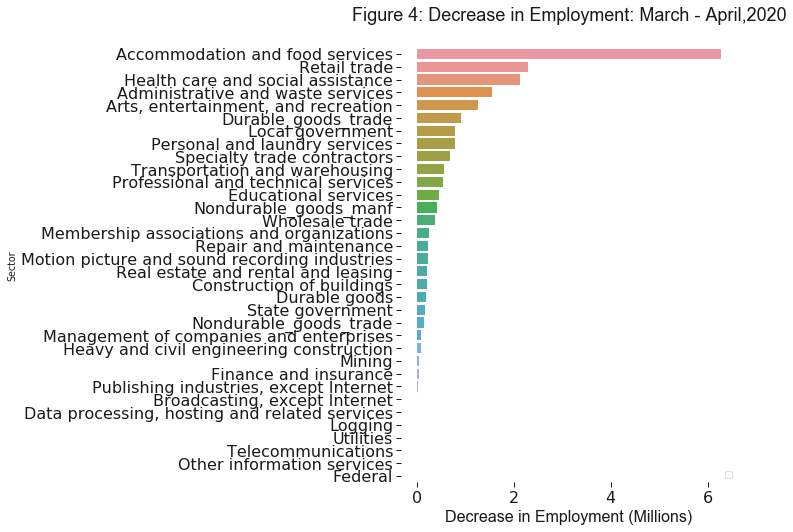

<Figure size 432x288 with 0 Axes>

In [88]:
# plot the data for subsectors
sns.set_context('paper')

f, ax = plt.subplots(figsize = (6,8))
sns.set_color_codes('pastel')
sns.barplot(x = 'Decrease_mar_apr', y = 'Sector', data = overall,dodge= False)#,ci =None)
sns.set_color_codes('muted')
ax.legend(ncol = 2, loc = 'lower right')
# Set the labels for the x ticks
ax.set_xlabel('Decrease in Employment (Millions)',fontsize=font_s,fontname='Arial')
ax.tick_params(axis="x", labelsize=font_s)
ax.tick_params(axis="y", labelsize=font_s)
# Set the chart's title
ax.set_title('Figure 4: Decrease in Employment: March - April,2020\n',fontsize = font_s+2,fontname='Arial')
sns.despine(left = True, bottom = True)
plt.show()
plt.savefig('unemployment_by_sectors.png')

C:\Users\shamabar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
No handles with labels found to put in legend.


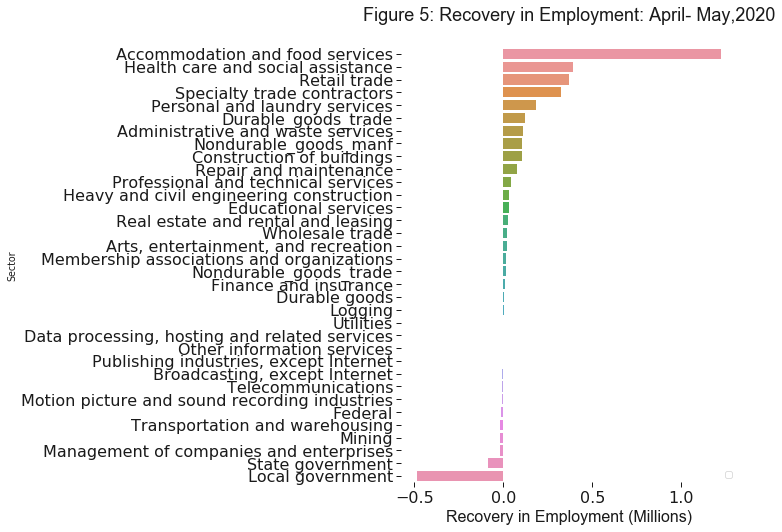

<Figure size 432x288 with 0 Axes>

In [89]:
# plot the data for subsectors
overall.sort_values(by='Change', ascending=False,inplace= True)


sns.set_context('paper')

f, ax = plt.subplots(figsize = (6,8))
sns.set_color_codes('pastel')
sns.barplot(x = 'Change', y = 'Sector', data = overall,dodge= False)#,ci =None)
sns.set_color_codes('muted')
ax.legend(ncol = 2, loc = 'lower right')
# Set the labels for the x ticks
ax.set_xlabel('Recovery in Employment (Millions)',fontsize=font_s,fontname='Arial')
ax.tick_params(axis="x", labelsize=font_s)
ax.tick_params(axis="y", labelsize=font_s)
# Set the chart's title
ax.set_title('Figure 5: Recovery in Employment: April- May,2020\n',fontsize = font_s+2,fontname='Arial')
sns.despine(left = True, bottom = True)
plt.show()
plt.savefig('unemployment_by_sectors.png')